In [ ]:
import numpy as np
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
from PIL import Image

In [ ]:
preprocess_image=transforms.Compose([
    transforms.Resize((200,200)),
    transforms.ToTensor()
])

In [ ]:
content_image_path="/content/Hamburg.jpg"
style_image_path="/content/The_Great_Wave_off_Kanagawa.jpg"

In [ ]:
content_image=Image.open(content_image_path).convert("RGB")
content_image=preprocess_image(content_image)
content_image=torch.unsqueeze(content_image,dim=0)
content_image.shape

torch.Size([1, 3, 200, 200])

In [ ]:
style_image=Image.open(style_image_path).convert("RGB")
style_image=preprocess_image(style_image)
style_image=torch.unsqueeze(style_image,dim=0)
style_image.shape

torch.Size([1, 3, 200, 200])

In [ ]:
from torchvision import models

In [ ]:
vgg=models.vgg19(pretrained=True).features

In [ ]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
for params in vgg:
  params.requires_grad_(False)

In [ ]:
loss_layers={"0":"conv1_1",
             "5":"conv2_1",
             "10":"conv3_1",
             "19":"conv4_1",
             "21":"conv4_2",
             "28":"conv5_1"}

In [ ]:
vgg._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace=Tru

In [ ]:

def extract_features(image,model):
  features={}
  for name,layer in model._modules.items():
    image=layer(image)
    if name in loss_layers:
      features[loss_layers[name]]=image

  return features


In [ ]:
content_image_features=extract_features(content_image,vgg)

In [ ]:
style_image_features=extract_features(style_image,vgg)

In [ ]:
def cal_gram_matrix(tensor):
  _,C,H,W=tensor.size()
  tensor=tensor.view(C,H*W)
  gram_matrix=torch.mm(tensor,tensor.T)
  gram_matrix=gram_matrix.div(C*H*W)
  return gram_matrix

In [ ]:
style_feature_gram_matrix={layer: cal_gram_matrix(style_image_features[layer]) for layer in style_image_features}

In [ ]:
weights={"conv1_1":1,
         "conv2_1":0.8,
         "conv3_1":0.6,
         "conv4_1":0.4,
         "conv5_1":0.2}

In [ ]:
target_image = content_image.clone().requires_grad_(True)

In [ ]:
optimizer=torch.optim.Adam([target_image],lr=0.003)

In [ ]:
target_image_features=extract_features(target_image,vgg)

In [ ]:
from torch.nn.functional import mse_loss

In [ ]:
 target_image_features=extract_features(target_image,vgg)

In [ ]:

for i in range(1,100):
  target_image_features=extract_features(target_image,vgg)

  content_loss=mse_loss(target_image_features["conv4_2"],content_image_features["conv4_2"])

  style_loss=0
  for layer in weights:
    target_image_feature=target_image_features[layer]
    style_feature=style_feature_gram_matrix[layer]
    target_image_gram_matrix= cal_gram_matrix(target_image_feature)
    layer_loss=mse_loss(target_image_gram_matrix,style_feature)*weights[layer]
    style_loss+=layer_loss
  total_loss=style_loss*1000000+content_loss

  print(f"Epoch:{i},content_loss={content_loss},style_loss:{style_loss}")
  optimizer.zero_grad()
  total_loss.backward(retain_graph=True)
  optimizer.step()



Epoch:1,content_loss=0.0,style_loss:1.351834725937806e-05
Epoch:2,content_loss=0.08464845269918442,style_loss:1.2544818673632108e-05
Epoch:3,content_loss=0.2586655616760254,style_loss:1.1684233868436422e-05
Epoch:4,content_loss=0.43650785088539124,style_loss:1.0899490007432178e-05
Epoch:5,content_loss=0.6287340521812439,style_loss:1.0165419553231914e-05
Epoch:6,content_loss=0.8294128775596619,style_loss:9.474942089582328e-06
Epoch:7,content_loss=1.0032663345336914,style_loss:8.846703167364467e-06
Epoch:8,content_loss=1.1430633068084717,style_loss:8.282057024189271e-06
Epoch:9,content_loss=1.2535172700881958,style_loss:7.770402589812875e-06
Epoch:10,content_loss=1.3410056829452515,style_loss:7.304314294742653e-06
Epoch:11,content_loss=1.409529447555542,style_loss:6.87912597641116e-06
Epoch:12,content_loss=1.4660037755966187,style_loss:6.491850854217773e-06
Epoch:13,content_loss=1.5167198181152344,style_loss:6.1363498389255255e-06
Epoch:14,content_loss=1.56308913230896,style_loss:5.80913

In [ ]:
for i in range(1, 100):

    target_features = extract_features(target_image, vgg)

    content_loss = mse_loss (target_image_features['conv4_2'], content_image_features['conv4_2'])

    style_loss = 0
    for layer in weights:

        target_feature = target_image_features[layer]
        target_gram_matrix = cal_gram_matrix(target_feature)
        style_gram_matrix = style_feature_gram_matrix[layer]

        layer_loss = mse_loss (target_gram_matrix, style_gram_matrix) * weights[layer]
        # layer_loss *= weights[layer]


        style_loss += layer_loss

    total_loss = 1000000 * style_loss + content_loss

    if i % 10 == 0:
        print (f"Epoch {i}:, Style Loss : {style_loss}, Content Loss : {content_loss}")

    optimizer.zero_grad()

    total_loss.backward(retain_graph=True)

    optimizer.step()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1, 3, 200, 200]] is at version 99; expected version 98 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
mean = (0.485, 0.456, 0.406)  # imagenet mean and std
std = (0.229, 0.224, 0.225)

In [ ]:
def tensor_to_image(tensor):
  image=tensor.clone().detach()
  image=image.cpu().numpy().squeeze()

  image=image.transpose(1,2,0)
  image=image*np.array(std)+np.array(mean)
  image=image.clip(0,1)
  return image


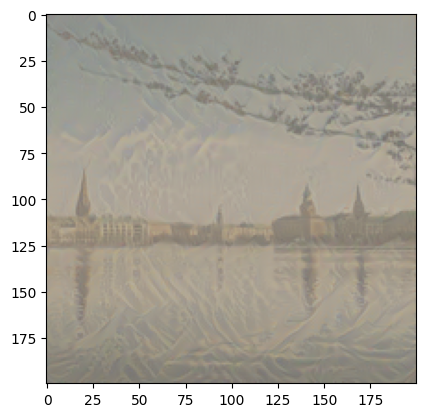

In [ ]:
import matplotlib.pyplot as plt
img=tensor_to_image(target_image)
plt.imshow(img)

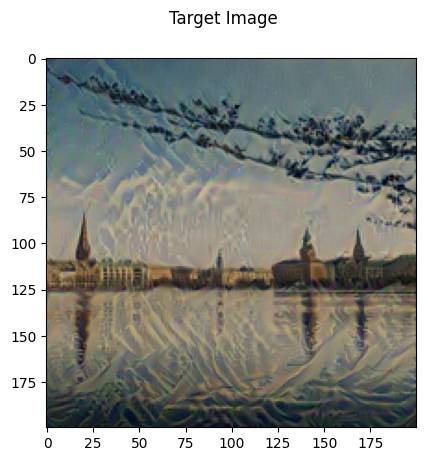

In [ ]:
mean = (0.485, 0.456, 0.406)  # imagenet mean and std
std = (0.229, 0.224, 0.225)
def tensor_to_image(tensor):

    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze()

    image = image.transpose(1, 2, 0)

    image =image* (np.array(std) + np.array(mean))
    image = image.clip(0, 1)

    return image

import matplotlib.pyplot as plt
img = tensor_to_image(target_image)
fig = plt.figure()
fig.suptitle('Target Image')
plt.imshow(img)
# %%
